In [2]:
# Import necessary libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
# Load the dataset.

df0 = pd.read_csv("C:/Users/DELL/Downloads/waze_dataset (1).csv")

In [4]:
#Check few rows of data.
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [5]:
# We will Create a copy of dataset so that original dataset remains unchanged.
df = df0.copy()

In [6]:
# Get the basic info about the data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [7]:
# Calculate kilometers per driving day.

df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

In [8]:
# We will check basic summary statistics.
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [9]:
# We will convert infinite values to zero.
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# We will check that it worked.
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [10]:
# Calculate percent sessions in the last month.
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

In [11]:
# We will check basic summary statistics for particular column.
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [12]:
# We created a new column to indicate professional drivers.

df['proffesional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15),1,0)

In [13]:
# We will calculate total sessions per day.

df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

In [14]:
# We will check basic summary statistics for particular column.
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [15]:
# We created `km_per_hour` column.
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)

# We check basic summary statistics.
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [16]:
# Calculate kilometers per drive.
df['km_per_drive'] = df['driven_km_drives'] / df['drives']

# We check basic summary statistics.
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [17]:
# We will convert infinite values to zero.
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# We will check that it worked.
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [18]:
# We created `percent_of_sessions_to_favorite` column.
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

In [19]:
# We will check for the null values.
df.isna().sum()

ID                                  0
label                             700
sessions                            0
drives                              0
total_sessions                      0
n_days_after_onboarding             0
total_navigations_fav1              0
total_navigations_fav2              0
driven_km_drives                    0
duration_minutes_drives             0
activity_days                       0
driving_days                        0
device                              0
km_per_driving_day                  0
percent_sessions_in_last_month      0
proffesional_driver                 0
total_sessions_per_day              0
km_per_hour                         0
km_per_drive                        0
percent_of_drives_to_favorite       0
dtype: int64

In [20]:
# We will now drop the null values.
df = df.dropna(axis=0)

In [21]:
# We will check that it worked.
df.isna().sum()

ID                                0
label                             0
sessions                          0
drives                            0
total_sessions                    0
n_days_after_onboarding           0
total_navigations_fav1            0
total_navigations_fav2            0
driven_km_drives                  0
duration_minutes_drives           0
activity_days                     0
driving_days                      0
device                            0
km_per_driving_day                0
percent_sessions_in_last_month    0
proffesional_driver               0
total_sessions_per_day            0
km_per_hour                       0
km_per_drive                      0
percent_of_drives_to_favorite     0
dtype: int64

In [22]:
# Create a new column to indicate the device type (0 for Android, 1 for other).
df['device2'] = np.where(df['device']=='Android', 0, 1)

# Display the last few rows of the DataFrame.
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


In [23]:
# Create a new column to indicate whether the label is 'retained' (0) or not (1)
df['label2'] = np.where(df['label'] == 'retained', 0, 1)

# Display the last few rows of the DataFrame.
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [24]:
# Drop `ID` column as it is not required.
df = df.drop(['ID'], axis=1)

In [25]:
# Calculate the proportion of each label.
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [26]:
# Split the data into features and target variable.
X = df.drop(columns=['label', 'label2', 'device'])

y = df['label2']   #Target variable

# Split the data into training and testing sets.
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

In [27]:
# Split the training data into training and validation sets.

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25,stratify=y_tr, random_state=42)

In [28]:
# Print the length of each dataset.
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


In [29]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2],
             'min_samples_split': [2],
             'n_estimators': [300],
             }

# 3. Define a dictionary of scoring metrics to capture
sc = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, cv=4, refit='recall')

In [30]:
# Train the model.
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall')

In [31]:
# Check for the best scores.
rf_cv.best_score_

0.8185098328288627

In [32]:
# Check for the best parameters.
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [33]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [34]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, cv=4, refit='recall')

In [35]:
# Now fit the XGBoost Model.
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5], 'n_estimators': [300]},
             refit='recall')

In [36]:
# Check for the best scores of XGBoost Model.
xgb_cv.best_score_

0.8242217126778694

In [37]:
# Check for the best parameters of XGBoost Model.
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 300}

In [38]:
# Make predictions on the validation set using the best estimator from cross-validation.

rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [39]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [40]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

In [41]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

In [42]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

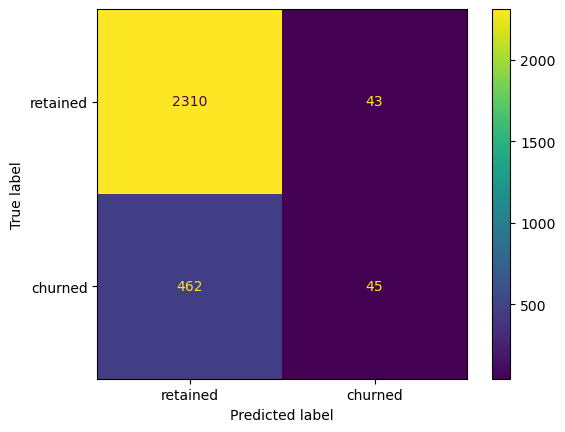

In [43]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

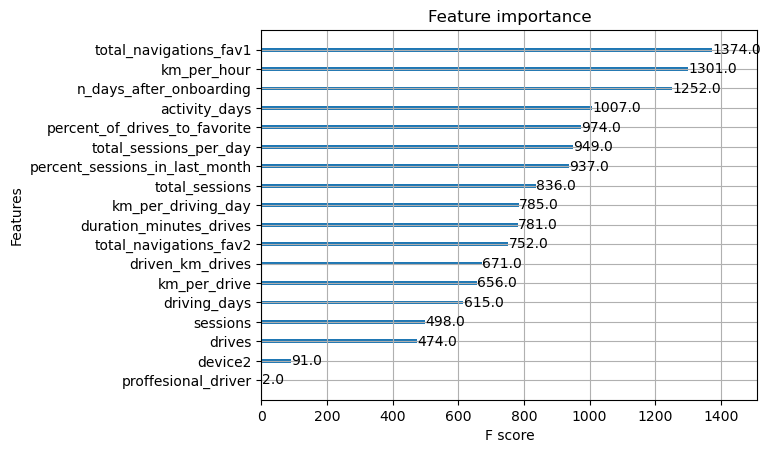

In [44]:
# Plot the best estimators.
plot_importance(xgb_cv.best_estimator_);